In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets 
from tabulate import tabulate
%matplotlib inline
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('NYC_FB_Final.csv')
df_dob = pd.read_csv('DOB_freq.csv')
df_fdny = pd.read_csv('NYC_FDNY_Final.csv')

In [3]:
# create list of all valid cuisines
cuisine_list = df['cuisine'].unique()
cuisine_list = cuisine_list.tolist()
cuisine_list.append('')

# create list of all valid zips
zip_list = df['zipcode'].unique()
zip_list = zip_list.tolist()
zip_list = [str(x) for x in zip_list]

# create list of all valid class types
class_list = df_fdny['Class'].unique()
class_list = class_list.tolist()
class_list.append('')

In [4]:
def f(cuisine_type, zip_code, class_type, indic):
    
    if (zip_code in zip_list):
        
        # plot graphs
        plt.close('all')
        fig, axes = plt.subplots(nrows=3, ncols=2)
        
        ###################
        ### HEALTH DATA ###
        ###################
        
        # slice dataframe by cuisine and zip
        df_temp = df.loc[df['cuisine'] == cuisine_type]
        df_temp = df_temp.loc[df_temp['zipcode'] == int(zip_code)]
        
        print ('Health results based on sample of ' + str(df_temp.shape[0]) + ' violations.')
        
        # if dataframe is not empty
        if df_temp.size != 0:
        
            ### FREQUENCY ###
        
            # aggregate fines by violation
            df_group = df_temp.groupby('violation').sum()
            df_group = df_group.reset_index(drop = False)
        
            # determine share of fine for each violation
            df_group['fine_share'] = (df_group['fine'] / df_group['fine'].sum()) * 100
            
            # sort dataframe and limit output
            df_group = df_group.sort_values(by='fine_share', ascending=0)
            df_group = df_group.reset_index(drop = True)
            df_indic = df_group[:indic]
            
            # plot
            ax1 = df_indic.plot(kind='bar', x='violation', y='fine_share',
                                 fontsize = 14, figsize=(15,5), legend = False,
                                 color = '#47b8e0', alpha = 1, ax = axes[0][0])
            
            ax1.set_xlabel("Violation Code", fontsize = 14)
            ax1.set_ylabel("Percentage of Fines Paid", fontsize = 14)
            ax1.set_title('Top ' + str(indic) + ' Highest Health Fines Paid')
            
            ### OVERPREVALENCE ###
            
            # slice dataframe by cuisine and zipcode
            df_temp = df.loc[df['cuisine'] == cuisine_type]
            df_temp = df_temp.loc[df_temp['zipcode'] == int(zip_code)]
            df_temp = df_temp[['violation', 'zipcode']]
            df_temp.columns = ['violation', 'count']
            
            # fine most frequent violations
            df_group = df_temp.groupby('violation').count()
            df_group = df_group.reset_index(drop = False)
            df_group['freq'] = df_group['count'] / df_group['count'].sum()

            # slice dataframe only by zipcode
            df_temp_zip = df.loc[df['zipcode'] == int(zip_code)]
            df_temp_zip = df_temp_zip[['violation', 'zipcode']]
            df_temp_zip.columns = ['violation', 'count']

            # find most frequent violations within entire zipcode
            df_group_zip = df_temp_zip.groupby('violation').count()
            df_group_zip = df_group_zip.reset_index(drop = False)
            df_group_zip['zipfreq'] = df_group_zip['count'] / df_group_zip['count'].sum()

            # merge two datasets
            df_temp_final = df_group.merge(df_group_zip, on = 'violation', how = 'inner')
            df_temp_final['overprev'] = (df_temp_final['freq'] - df_temp_final['zipfreq'])*1000
            df_temp_final = df_temp_final.sort_values(by='overprev', ascending=0)
            
            df_indic = df_temp_final[:indic]
            
            ax2 = df_indic.plot(kind='bar', x='violation', y='overprev',
                                 fontsize = 14, figsize=(15,5), legend = False,
                                 color = '#47b8e0', alpha = 1, ax = axes[0][1])
            
            ax2.set_xlabel("Violation Code", fontsize = 14)
            ax2.set_ylabel("Percentage of Fines Paid", fontsize = 14)
            ax2.set_title('Top ' + str(indic) + ' Most Over-Prevalent Health Violations')
            
        
        else:
            return 'Not enough input data for Health results.'
        
        ################
        ### DOB DATA ###
        ################
        
        # slice dataframe by cuisine and zip
        df_temp = df_dob.loc[df_dob['ZIPCODE'] == int(zip_code)]
        df_temp = df_temp.loc[df_temp['CLASS'] == class_type]
        
        print ('DOB results based on sample of ' + str(df_temp.shape[0]) + ' violations.')
        
        # if dataframe is not empty
        if df_temp.size != 0:
            
            ### FREQUENCY ###
            
            # sort by freq and plot
            df_temp = df_temp.sort_values(by='freq', ascending=0)
            
            df_indic = df_temp[:indic]
            
            ax3 = df_indic.plot(kind='bar', x='VIO_TYPE', y='freq',
                                 fontsize = 14, figsize=(15,15), legend = False,
                                 color = '#ffc952', alpha = 1, ax = axes[1][0])
            
            ax3.set_xlabel("Violation Code", fontsize = 14)
            ax3.set_ylabel("Frequency of Violation", fontsize = 14)
            ax3.set_title('Top ' + str(indic) + ' Most Frequent DOB Violations')
            
            ### OVERPREVALENCE ###
            
            # sort by overprevalence and plot
            df_temp = df_temp.sort_values(by='overprev', ascending=0)
            
            df_indic = df_temp[:indic]
            df_indic = df_indic[df_indic['overprev'] > 0]
            
            ax4 = df_indic.plot(kind='bar', x='VIO_TYPE', y='overprev',
                                 fontsize = 14, figsize=(15,15), legend = False,
                                 color = '#ffc952', alpha = 1, ax = axes[1][1])
            
            ax4.set_xlabel("Violation Code", fontsize = 14)
            ax4.set_ylabel("Overprevalence of Violation", fontsize = 14)
            ax4.set_title('Top ' + str(indic) + ' Most Over-Prevalent DOB Violations')
            
        else:
            return 'Not enough input data for DOB results.'
        
        #################
        ### FDNY DATA ###
        #################
        
        # slice dataframe by zip and class
        df_temp = df_fdny.loc[df_fdny['ZIPCODE'] == int(zip_code)]
        df_temp = df_temp.loc[df_temp['Class'] == class_type]
        
        print ('FDNY results based on sample of ' + str(df_temp.shape[0]) + ' violations.')
        
        # if dataframe is not empty
        if df_temp.size != 0:
            
            ### FREQUENCY ###
            
            # sort by freq and plot
            df_temp = df_temp.sort_values(by='freq', ascending=0)
            
            df_indic = df_temp[:indic]
            
            ax5 = df_indic.plot(kind='bar', x='Code', y='freq',
                                 fontsize = 14, figsize=(15,15), legend = False,
                                 color = '#ff7473', alpha = 1, ax = axes[2][0])
            
            ax5.set_xlabel("Violation Code", fontsize = 14)
            ax5.set_ylabel("Frequency of Violation", fontsize = 14)
            ax5.set_title('Top ' + str(indic) + ' Most Frequent FDNY Violations')
            
            ### OVERPREVALENCE ###
            
            # sort by overprevalence and plot
            df_temp = df_temp.sort_values(by='overprev', ascending=0)
            
            df_indic = df_temp[:indic]
            df_indic = df_indic[df_indic['overprev'] > 0]
            
            ax6 = df_indic.plot(kind='bar', x='Code', y='overprev',
                                 fontsize = 14, figsize=(15,15), legend = False,
                                 color = '#ff7473', alpha = 1, ax = axes[2][1])
            
            ax6.set_xlabel("Violation Code", fontsize = 14)
            ax6.set_ylabel("Overprevalence of Violation", fontsize = 14)
            ax6.set_title('Top ' + str(indic) + ' Most Over-Prevalent FDNY Violations')
            
        else:
            return 'Not enough input data for FDNY results.'
    
    else:
        return 'No data.'
    
    plt.tight_layout()

In [5]:
# initialize cuisine widget
cuisine_widget = widgets.Dropdown(
    options = cuisine_list,
    value = '',
    description = 'Cuisine type:',
)

In [6]:
# initialize zip widget
zip_widget = widgets.Text(
    value = '',
    description = 'ZIP Code:',
    width = 70
)

In [7]:
# initialize class widget
class_widget = widgets.Dropdown(
    options = class_list,
    value = '',
    description = 'Building class type:',
    width = 30
)

In [8]:
# initialize violations widget
violations_widget = widgets.IntSlider(
    min = 1,
    max = 10,
    step = 1,
    value = 5,
    description = 'Fines to show:',
)

In [9]:
# initialize dashboard
dashboard = interactive(f,
                        cuisine_type = cuisine_widget,
                        zip_code = zip_widget,
                        class_type = class_widget,
                        indic = violations_widget)

<h1> Restaurant Dashboard </h1> 

Health results based on sample of 265 violations.
DOB results based on sample of 2 violations.
FDNY results based on sample of 9 violations.


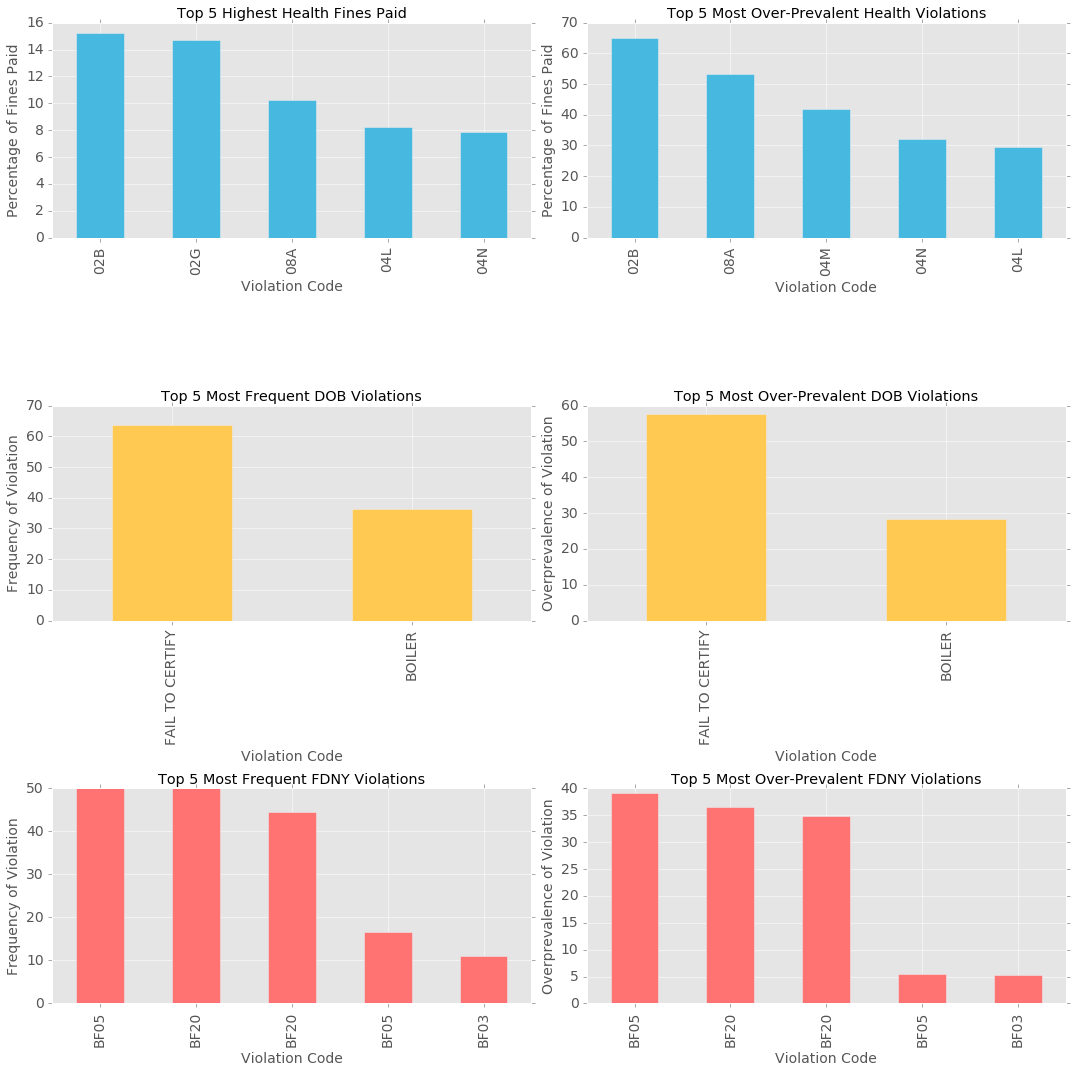

In [10]:
display(dashboard)